# 🖼️ IMAGE DATA PROCESSING OR GENERATION, IN GENERAL
- [Classification resources](https://www.uspto.gov/web/patents/classification/cpc/html/cpc-G06T.html)
- [Data](https://gerdes.fr/saclay/informationRetrieval/patentFiles/G06T.txt.gz)
- [Github](https://github.com/danaaubakirova/Information-Retrieval-FP)

## 🪐 Authors
- Dana AUBAKIROVA
- Benedicutus Kent RACHMAT

# 🏁 Introduction
The surge in digital data and the widespread adoption of machine learning techniques have led to significant advancements in image processing and computer vision technologies and these innovations have found applications in various industries such as healthcare, robotics, and autonomous vehicles, etc. Consequently, there has been a substantial increase in the number of patents filed in the domain of image data processing and generation. Efficiently navigating this complex patent landscape and extracting relevant relationships between technical terms is indeed essential for researchers, inventors, and businesses to stay abreast of the latest developments and foster innovation.

The project focuses on patents in the field of image data processing and generation, encompassing areas such as image recognition, computer vision, machine learning techniques for image processing, and image enhancement methods. By identifying critical terms and their connections, the project aims to provide a valuable tool for users to navigate the vast patent landscape effortlessly. The final knowledge graph will facilitate patent analysis.

Our primary objective of this project is to detect terms and captures the relationships between technical terms in patents related to image data processing or generation (G06T). Before diving to the project, we have divided the notebook into 2 big section : 

- Term Detection: Identifying and extracting significant technical terms from patent documents to establish a well-defined vocabulary that accurately represents the domain.

- Relation Detection: Determining the relationships between the identified technical terms and create a graph that captures the underlying structure and connections within the domain.

# 🛠️ Methodology
To train our model, we pre-processed patent data and used the [Spacy library](https://spacy.io/) to fine-tune it with [Prodigy](https://prodi.gy/). We experimented with various language models, including en_core_web_lg, en_core_web_trf, and en_core_sci_sm. We chose to use en_core_sci_sm, a full Spacy pipeline for biomedical data with a larger vocabulary and 50k word vectors, as we believed that terms in biomedical data and image processing share similarities. 

# 📥 Imports

Uncomment this lines if you want to use pretrained models and detect terms in the text. We revealed that spacy-transformers and scispacy are using different versions of spacy, which makes them incompatible to be used together. 

In [ ]:
# !pip install scispacy

Uncomment this line if you don't have the text file or the necessary libraries to run the whole notebook. 

To save time in the future, kindly download our package containing three pre-trained models along with the corresponding text in the [Google Drive](https://drive.google.com/drive/folders/1WbsLBncIfR2TehKTEgkKnRpUHKTGg12V?usp=sharing) and put it in the root directory of the project.

In [38]:
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_sm
# !pip install spacy==3.4.4
# !pip install nltk
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_trf-3.2.0/en_core_web_trf-3.2.0-py3-none-any.whl

In [39]:
# !wget https://gerdes.fr/saclay/informationRetrieval/patentFiles/G06T.txt.gz -P texts
# !gzip -d G06T.txt.gz

In [105]:
import re
import nltk
from lib import *
import numpy as np
import pandas as pd 
import networkx as nx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy
from spacy.vocab import Vocab
from spacy.tokens import Span, DocBin
from spacy.training import Example
from spacy.util import filter_spans
from scispacy.hyponym_detector import HyponymDetector
from spacy.matcher import PhraseMatcher, DependencyMatcher, Matcher

from nltk.corpus import wordnet as wn

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kentrachmat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 🌐 Exploratory Analysis

In [41]:
FUNKY_COLOR = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"

In [42]:
g06t = open('texts/G06T.txt').read().strip()
patent_texts = g06t.split('\n\n')
patent_lines = g06t.split('\n')

print(len(patent_lines), 'paragraphs of patent text')

# large english pre-trained language model
nlp = spacy.load("en_core_web_lg")
shorttext = patent_texts[0][18000:20000]
doc = nlp(shorttext)
displacy.render(doc, style="ent", jupyter=True)

298995 paragraphs of patent text


/usr/local/anaconda3/lib/python3.9/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'en_core_web_lg' (3.4.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


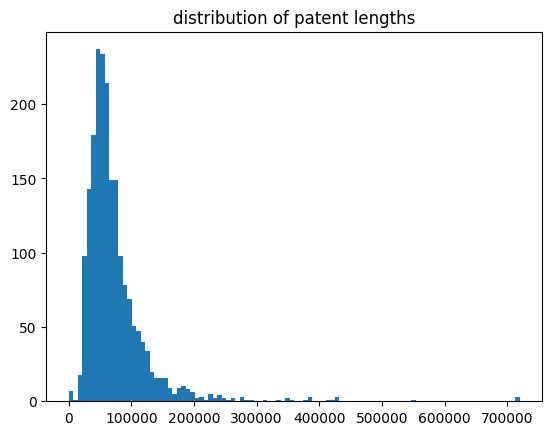

In [43]:
patent_lengths = [len(p) for p in patent_texts]
plt.hist(patent_lengths, bins=100)
plt.title("distribution of patent lengths")
plt.show()

The function extracts reference numerals and their corresponding terms from a given text. It filters out unwanted terms and returns a dictionary with reference numerals as keys and lists of related terms as values. This helps the model to remove ambigiouty from the numbers

In [44]:
num2termlist = rawExtractRefs(shorttext)
print("References numbers and terms:")
display(num2termlist)

References numbers and terms:


{400: ['method'],
 401: ['begins at step'],
 102: ['background data stream'],
 402: ['step'],
 101: ['foreground data stream'],
 403: ['step'],
 404: ['step'],
 100: ['high bit rate stream'],
 406: ['step']}

The function looks for groups of related words, called "noun chunks", in the document and it skips the ones that have certain words from the "exclude_list" and filters out unwanted words like those from the "remove_list", determiners, and punctuation we also remove the References numbers. Tt prepares a simplified version of the text and uses the function to find the noun chunks. 

Noun chunks are groups of words that revolve around a noun. They provide more information about the noun and often include words like adjectives, determiners, or other related words. For example, in the phrase "a delicious chocolate cake" : "delicious" and "chocolate" are words that describe the noun "cake", and the whole phrase forms a noun chunk that provides more information about the cake.

In [8]:
remove_list = ['r']
exclude_list = ['FIG', 'FIGS']
cleanNshort = removeNumbers(shorttext, num2termlist)
doc = nlp(cleanNshort) 

noun_chunks = get_noun_chunks_v2(doc, remove_list, exclude_list)

displacy.render({'text': cleanNshort, 'ents': noun_chunks, 'title': "Improved Noun Chunks without determiners"},
                style='ent', options={'colors': {"NC": FUNKY_COLOR}}, manual=True, jupyter=True)

Adding the predicates

In [9]:
doc = nlp(cleanNshort)
displacy.render(doc, style="dep")
noun_chunks = get_noun_chunks_v2(doc, remove_list, exclude_list)
predicates, sources, targets = get_predicates_between_noun_chunks(doc, noun_chunks)

displacy.render({'text': cleanNshort, 'ents': noun_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": FUNKY_COLOR}})

## ⚛️ Semantic Graph Representation 

Semantic Graph Representation is a way to visually show the meaning of a piece of text. Usually the noddes and edges represent words and their relationships. It helps us understand how words are connected and how they work together to convey the meaning in the text.

inspired by [Knowledge-Graph-Spacy](https://www.kaggle.com/code/cananserper/knowledge-graph-spacy) 

In [12]:
df = pd.DataFrame({'source': [str(s) for s in sources], 'target': [str(t) for t in targets], 'edge': [r['text'] for r in predicates]})
df.head(10)

,source,target,edge
0,method,variation,is
1,variation,widely known MPEG-DASH standard,of
2,available streams,previous embodiments,to
3,method,step,at
4,step,reception,with
5,reception,subsequent presentation,for
6,subsequent presentation,background data stream,of
7,background data stream,information,on
8,information,information data,present in blending
9,information data,other information,on


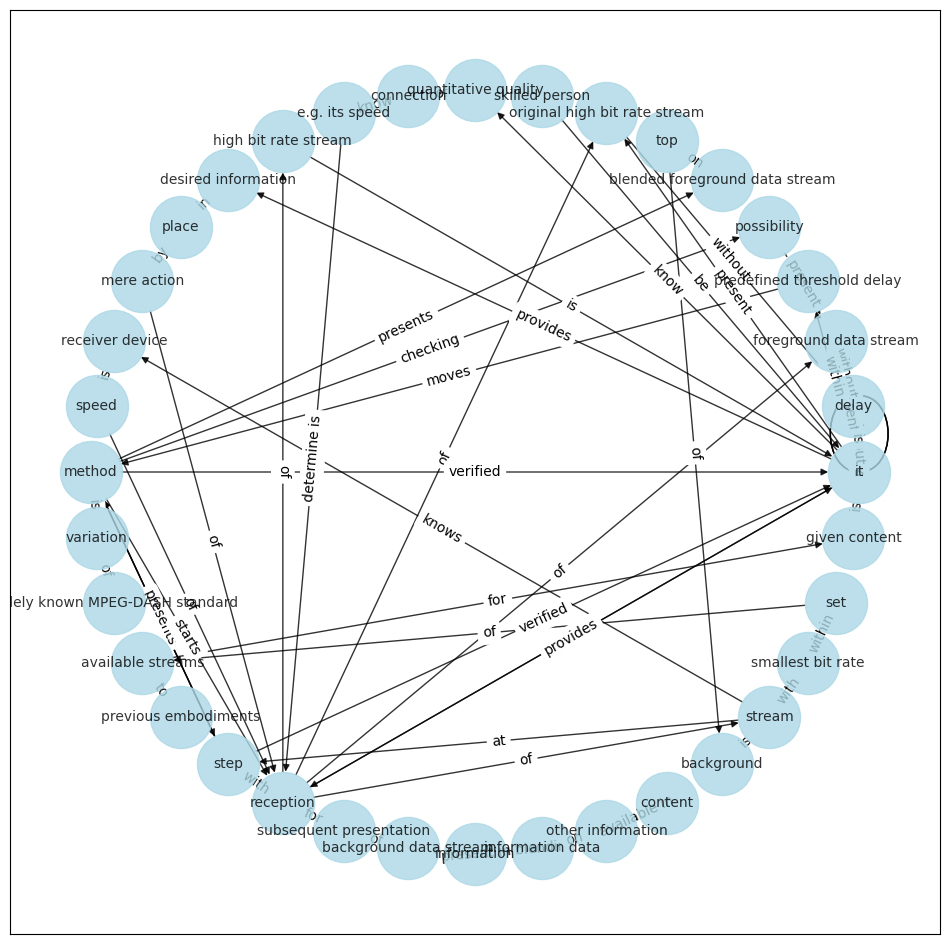

In [13]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.shell_layout(G)
nx.draw_networkx(G, with_labels=True, pos=pos, node_size=2000, node_color='lightblue', edge_color='black', width=1, alpha=0.8, font_size=10)

edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()



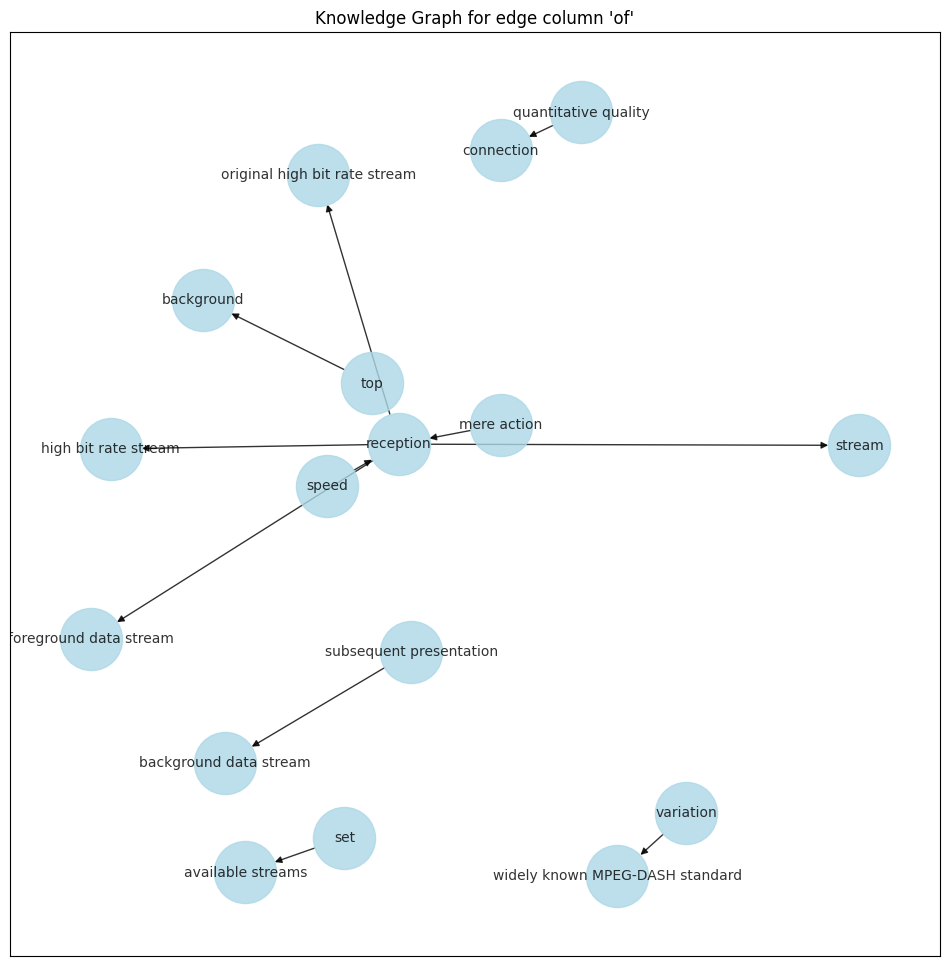

In [14]:
G=nx.from_pandas_edgelist(df[df['edge']=="of"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw_networkx(G, with_labels=True, pos=pos, node_size=2000, node_color='lightblue', edge_color='black', width=1, alpha=0.8, font_size=10)
plt.title("Knowledge Graph for edge column 'of'")
plt.show()

# 🧹 Data Cleaning 

This code splits a collection of text lines from patents into two parts: 70% for training (train_lines) and 30% for testing (test_lines). Then, it processes the first 50,000 lines of the training set and the first 7,000 lines of the testing set. The processing involves extracting reference numbers.

In [45]:
train_lines, test_lines = train_test_split(patent_lines, test_size=0.3, random_state=42)

In [30]:
for i,lines in enumerate(train_lines[:50000]):
    try:
        num2termlist = rawExtractRefs(lines)
        cleanNshort = removeNumbers(lines, num2termlist)
        test_lines[int(i)] = cleanNshort
    except:
        pass

In [27]:
for i,lines in enumerate(test_lines[:7000]):
    num2termlist = rawExtractRefs(lines)
    cleanNshort = removeNumbers(lines, num2termlist)
    test_lines[int(i)] = cleanNshort

## 🔍 Term Detection with Spacy and Prodigy

Spacy is a tool that helps computers understand and process human language. It can analyze text to find things like words, sentences, and their meanings. Thanks to its functionallity we can train and make the model suits our dataset moreover the hyperparameter configuration is relatively easy to modify.

Prodigy is another tool that works with Spacy to make it easier for people to teach computers about language. It's like a training program where we can show the computer examples of what you want it to learn. With Prodigy, we can give feedback on the computer's work and help it improve its understanding of language.

In [15]:
cvectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', min_df=500)  
X=cvectorizer.fit_transform(patent_lines)
Xdf = pd.DataFrame(np.sum(X, axis=0), columns=cvectorizer.get_feature_names_out()).T.sort_values(by = 0, ascending = False)

Xdf.columns = ['count']
Xdf.head(10)

,count
image data,27634
image processing,20995
present invention,17756
according embodiment,14986
present disclosure,14878
electronic device,11964
processing unit,11779
embodiment present,11362
shown fig,10331
control unit,9676


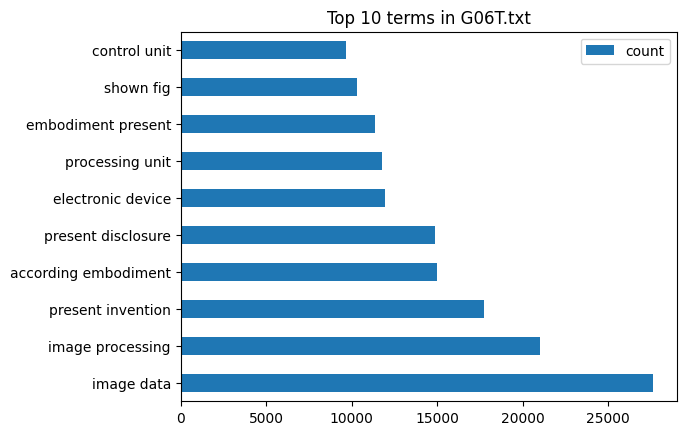

In [16]:
top_10 = Xdf.head(10)
top_10.plot.barh()
plt.title("Top 10 terms in G06T.txt")
plt.show()

### 🏃‍♀️ Training Spacy/SciSpacy/Transformer

Due to the extensive computational requirements associated with training transformer models and SpaCy-based models for scientific text, we have opted to leverage Kaggle's powerful computing infrastructure. The training process for transformers can be found at the following Kaggle [link](https://www.kaggle.com/code/kentrachmat/ir-transformers/output). Similarly, the training process for the SciSpacy model is accessible at this [link](https://www.kaggle.com/code/kentrachmat/ir-scispacy/output).

In [17]:
def Dataset(split, dataset):
    LABEL = "ENTITY"
    doc_bin = DocBin()  

    for training_example in tqdm(dataset):  
        doc = nlp(training_example) 
        new_ents = []
        ents = list(doc.ents)

        for i in range(len(doc.ents)-1):
            k = i+1
            new_ent = ents[i]
            next_ent = ents[k]

            # check if there's only a space between
            # in that case, merge them
            while doc.text[new_ent.end_char:next_ent.start_char] == ' ':
                k += 1
                new_ent = Span(doc, new_ent.start, next_ent.end, label=LABEL)
                if k >= len(ents):
                    break
                # next entity to see if can be merged
                next_ent = ents[k]

            # don't add the entities with trailing spaces
            if new_ent.text.strip() != new_ent.text:
                continue
                
            new_ents.append(new_ent)

        filtered_ents = filter_spans(ents)
        doc.ents = filtered_ents 
        doc_bin.add(doc)

    doc_bin.to_disk("{}_data.spacy".format(split))
    print("Saved {} docs to {}".format(len(doc_bin), "{}_data.spacy".format(split)))
    return doc_bin

In [18]:
# English transformer pipeline (roberta-base)
nlp = spacy.load("en_core_web_trf")
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in Xdf.index]
matcher.add("TT", patterns)

doc_bin_train = Dataset('trf_train',train_lines[:50000])
doc_bin_val = Dataset('trf_val', test_lines[:5000])
doc_bin_test = Dataset('trf_test', test_lines[5000:7000])

  0%|          | 0/50000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors


Saved 50000 docs to train_data.spacy


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 docs to val_data.spacy


  0%|          | 0/2000 [00:00<?, ?it/s]

Saved 2000 docs to test_data.spacy


In [21]:
# normal English pipeline
nlp = spacy.load("en_core_web_sm")
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in Xdf.index]
matcher.add("TT", patterns)

doc_bin_train = Dataset('train',train_lines[:50000])
doc_bin_val = Dataset('val', test_lines[:5000])
doc_bin_test = Dataset('test', test_lines[5000:7000])

In [22]:
# full ScispaCy pipeline for biomedical
nlp = spacy.load("en_core_sci_sm")
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(text) for text in Xdf.index]
matcher.add("TT", patterns)

doc_bin_train = Dataset('sci_train',train_lines[:50000])
doc_bin_val = Dataset('sci_val', test_lines[:5000])
doc_bin_test = Dataset('sci_test', test_lines[5000:7000])

  0%|          | 0/50000 [00:00<?, ?it/s]

Saved 50000 docs to train_data.spacy


  0%|          | 0/5000 [00:00<?, ?it/s]

Saved 5000 docs to val_data.spacy


  0%|          | 0/2000 [00:00<?, ?it/s]

Saved 2000 docs to test_data.spacy


In [ ]:
# !python -m spacy init fill-config config/base_config.cfg config/sci_spacy_config.cfg
# !python -m spacy train config.cfg --output ./sci_spacy_output --paths.train ./sci_train_data.spacy --paths.dev ./sci_val_data.spacy

In [65]:
nlp_ner = spacy.load("./old_spacy_output/model-best")
doc = nlp_ner(patent_lines[5])
spacy.displacy.render(doc, style="ent", jupyter=True)

In [68]:
nlp_ner = spacy.load("./sci_spacy_output/model-best")
doc = nlp_ner(patent_lines[5])
spacy.displacy.render(doc, style="ent", jupyter=True)

### 📝 Evaluation

In [91]:
# Load the trained model
model_path = "sci_spacy_output/model-best"
nlp_a = spacy.load(model_path)

In [92]:
nlp = spacy.load("en_core_sci_sm")

doc_bin = DocBin().from_disk('spacy_data/sci_test_data.spacy')
examples = []
for doc in doc_bin.get_docs(nlp.vocab):
    entities = []
    for ent in doc.ents:
        entities.append((ent.start_char, ent.end_char, ent.label_))
    spacy_entry = (doc.text, {"entities": entities})
    examples.append(Example.from_dict(nlp.make_doc(spacy_entry[0]), spacy_entry[1]))


In [ ]:
!python -m spacy evaluate sci_spacy_output/model-best spacy_data/sci_test_data.spacy --gold-preproc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
ℹ Using GPU: 0

================================== Results ==================================

TOK      100.00
TAG      96.42 
POS      93.16 
MORPH    95.00 
LEMMA    98.78 
UAS      86.75 
LAS      83.72 
NER P    91.27 
NER R    92.71 
NER F    91.98 
SENT P   99.58 
SENT R   99.81 
SENT F   99.69 
SPEED    16387 


============================== MORPH (per feat) ==============================

                 P        R        F
NumType      98.03    95.95    96.98
PunctType    99.98    99.90    99.94
Definite     99.99    99.99    99.99
PronType     99.93    99.94    99.94
Number       96.99    96.64    96.82
Aspect       94.31    92.21    93.25
Tense        95.90    93.22    94.54
VerbForm     94.16    93.73    93.95
Person       64.

In this particular case, the entity-level metrics are of most interest, as they evaluate how well the model predicts named entities in the text, which is **technical terms** in our case. The ents_p metric (entity precision) measures the proportion of predicted named entities that are correct, while the **ents_r** metric (entity recall) measures the proportion of actual named entities that were correctly predicted. The **ents_f** metric (entity F1-score) is the harmonic mean of **ents_p** and **ents_r**, and provides a balanced measure of both precision and recall.

In the given results, the model achieved an entity precision of 0.915, an entity recall of 0.927, and an entity F1-score of 0.921. These scores indicate that the model is performing reasonably well in identifying named entities in the text, but there may be room for improvement.

Note that ENTs per type and ENTs overall are same, because we are training on one entity, which is technical terms in this task.

In [ ]:
# Transformer pipeline
!python -m spacy evaluate  trf_spacy_output/model-best spacy_data/trf_test_data.spacy --gold-preproc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
ℹ Using GPU: 0

================================== Results ==================================

TOK      100.00
UAS      94.68 
LAS      93.34 
NER P    88.79 
NER R    92.90 
NER F    90.80 
SENT P   92.60 
SENT R   98.34 
SENT F   95.38 
SPEED    8218  


=============================== LAS (per type) ===============================

                P       R       F
meta        92.58   91.92   92.25
det         98.65   98.67   98.66
compound    93.27   91.43   92.34
amod        92.91   92.79   92.85
root        91.68   97.34   94.43
prep        92.54   92.88   92.71
pobj        97.53   97.81   97.67
nummod      93.15   94.77   93.95
advmod      91.58   92.87   92.22
nsubj       96.46   94.31   95.37
advcl       77.32   77.82   77.57
dobj 

From the Spacy-Transformers scores we can infer that something went wrong with data preprocessing steps, and the model didn't get our Technical Terms labels correctly. So, it trained on available labels for entities within the model itself. Correspondingly, If the training data was not preprocessed properly, the model may not have been able to learn the relevant patterns and features for the technical terms entity. Additionally, if the label for technical terms was not distinguished from other labels in the data, this could also lead to lower performance. Because we are using only one type of entity, which is technical terms in this task. 

In [ ]:
# Evaluate the model on the examples
evaluation_results = nlp_a.evaluate(examples)

# Print the evaluation metrics
print(evaluation_results)

{'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'tag_acc': None, 'pos_acc': None, 'morph_acc': None, 'morph_micro_p': None, 'morph_micro_r': None, 'morph_micro_f': None, 'morph_per_feat': None, 'lemma_acc': None, 'sents_p': 1.0, 'sents_r': 1.0, 'sents_f': 1.0, 'dep_uas': None, 'dep_las': None, 'dep_las_per_type': None, 'ents_p': 0.9149983071888049, 'ents_r': 0.9270718990120747, 'ents_f': 0.9209955357649973, 'ents_per_type': {'ENTITY': {'p': 0.9149983071888049, 'r': 0.9270718990120747, 'f': 0.9209955357649973}}, 'speed': 7920.6043560100925}


In [ ]:
results_df = pd.DataFrame.from_dict(evaluation_results, orient="index", columns=["Score"])

# Print the DataFrame to the console
print("Evaluation Results:")
results_df

Evaluation Results:


,Score
token_acc,1.0
token_p,1.0
token_r,1.0
token_f,1.0
tag_acc,None
pos_acc,None
morph_acc,None
morph_micro_p,None
morph_micro_r,None
morph_micro_f,None


In [115]:
test_lines[10002:10004]

['11. The apparatus of any previous claim further comprising a capture processor (701) for determining a capture property of the scene in response to the relative placement vector, the capture property being indicative of how the scene is covered by the images captured by the plurality of depth-sensing cameras; and a user interface (703) for generating a user output indicative of the capture property.',
 'With reference to any one of the first aspect and the first to the sixth implementations of the first aspect, in an eighth implementation of the first aspect, the size of the overlapping region is determined based on a size of the first region or the neighboring region.']

### 💯 Spacy-transformers predictions

In [ ]:
nlp_ner = spacy.load("trf_spacy_output/model-best")

colors = {"TECH": "#7DF6D9", "TECH_M": "#7DF6D9"}
options = {"colors": colors} 

for line in test_lines[10002:10004]:
    doc = nlp_ner(line)
    spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

### 💯 SciSpacy predictions

In [ ]:
nlp_ner = spacy.load("sci_spacy_output/model-best")

colors = {"TECH": "#7DF6D9", "TECH_M": "#7DF6D9"}
options = {"colors": colors} 

for line in test_lines[10002:10004]:
    doc = nlp_ner(line)
    spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

/opt/conda/lib/python3.10/site-packages/spacy/util.py:887: UserWarning: [W095] Model 'en_core_sci_sm' (0.5.1) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  


### 👓 Compraison

From the results we can infer that scispacy compared to spacy-transformers perform better for the following reasons:
   
   1. It is possible that the data used to train the scispacy model was preprocessed more accurately, leading to better performance in identifying technical terms.
   
   2. Scispacy has been specifically designed for working with scientific text which contains a lot of terms and has a number of features that are tailored to this domain, such as specialized tokenization and named entity recognition. This could give it an advantage over spacy-transformers, which is a more general-purpose NLP library.
   
   3. Scispacy uses a custom-built tokenizer that is optimized for scientific text, whereas spacy-transformers uses a pre-trained tokenizer from the Hugging Face Transformers library. The custom-built tokenizer may be better able to handle the idiosyncrasies of scientific text, such as chemical formulas and symbols.
   
   4. Scispacy includes pre-trained models that are specifically trained on scientific text, such as biomedical literature, which may provide it with a better understanding of the language and terminology used in scientific writing.


### 💫 Prodigy 

[Beta Tester](https://support.prodi.gy/t/beta-testers-wanted-new-manual-dependencies-relations-ui-v1-10/2893)

In [51]:
!prodigy ner.teach ner_tech  spacy_output_img/model-best  texts/G06T.txt --label TT 

Using 1 label(s): TT
/usr/local/anaconda3/lib/python3.9/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.4.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)

✨  Starting the web server at http://localhost:8080 ...
Open the app in your browser and start annotating!

^C


In [ ]:
!prodigy ner.correct gold_tech  ./spacy/spacy_output/model-best  G06T.txt --label TECH_M

In [ ]:
!prodigy ner.silver-to-gold gold_tech ner_tech ./spacy/spacy_output/model-best --label TECH_M 

In [ ]:
!prodigy data-to-spacy ./spacy/prodigy_output --ner gold_tech --eval-split 0.3

In [ ]:
!prodigy train ./spacy/prodigy_output --ner gold_tech --eval-split 0.3 --base-model ./spacy/spacy_output/model-best 

In [ ]:
!prodigy stats ner_tech #--label TECH_M

In [ ]:
nlp_ner = spacy.load("./spacy_output/model-best")

colors = {"TECH": "#7DF6D9", "TECH_M": "#7DF6D9"}
options = {"colors": colors} 

for line in test_lines[10000:10010]:
    doc = nlp_ner(line)
    spacy.displacy.render(doc, style="ent", options= options, jupyter=True)

# 🫂 Relation Detection

### 🖇️ Holonyms and meronyms
Holonyms and meronyms are two types of semantic relationships between words. A holonym is a word that represents a whole of which another word is a part. A meronym is a word that represents a part or component of a larger whole. For example, "Paper" is a meronym of "Book" because a Paper is a part of a Book, and "Book" is the holonym in this relationship, as it represents the whole entity. 

This code preprocesses a given text about a tree using a custom-trained SciSpacy model, then extracts and prints meronyms and holonyms for each lemmatized word using NLTK's [WordNet](https://www.nltk.org/howto/wordnet.html). The output displays the part-whole relationships found in the text.

In [114]:
nlp = spacy.load("./sci_spacy_output/model-best")

def extract_meronyms_and_holonyms(word):
    meronyms = set()
    holonyms = set()

    for synset in wn.synsets(word):
        for meronym in synset.part_meronyms():
            meronyms.update(lemma.name() for lemma in meronym.lemmas())
        for holonym in synset.part_holonyms():
            holonyms.update(lemma.name() for lemma in holonym.lemmas())

    return meronyms, holonyms

def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

text = test_lines[12]
preprocessed_text = preprocess_text(text)

for word in preprocessed_text:
    meronyms, holonyms = extract_meronyms_and_holonyms(word)
    if meronyms:
        print(f"Meronyms of '{word}': {', '.join(meronyms)}")
    if holonyms:
        print(f"Holonyms of '{word}': {', '.join(holonyms)}")

Meronyms of 'in': Gary, em, Bloomington, Evansville, ligne, capital_of_Indiana, Fort_Wayne, Wabash, mil, South_Bend, Indianapolis, pica, Lafayette, Wabash_River, pica_em, mesh, Muncie
Holonyms of 'in': U.S., ft, United_States_of_America, U.S.A., midwestern_United_States, middle_west, Midwest, US, America, Corn_Belt, foot, United_States, the_States, USA
Meronyms of 'a': milliampere, picometre, mA, picometer, micromicron
Holonyms of 'a': millimicron, nm, abampere, abamp, nanometre, nanometer, micromillimetre, micromillimeter
Meronyms of 'base': sewage_works, grid, firehouse, transportation_system, penal_institution, water_supply, fire_station, water, penal_facility, sewage_system, power_grid, public_works, power_system, school_system, communication_equipment, water_system, transportation, gas_system, transit, main, sewer_system, communication_system
Holonyms of 'base': baseball_diamond, box, lamp, diamond, junction_transistor, transistor, vessel, electronic_transistor, explanation, const

## 🪞 Co-occurrence

extracts noun-to-noun co-occurrences from a given text by finding pairs of nouns connected by specific words (e.g., 'and', 'or', 'with', etc.) and returns these co-occurrences as triplets. We generates separate graphs for each unique connector word and displays the resulting graphs with titles indicating the connector word used.

In [171]:
nlp = spacy.load("./sci_spacy_output/model-best")

def get_co_occurrence(text):
    doc = nlp(text)
    matcher = Matcher(nlp.vocab)
    pattern = [{'POS': 'NOUN'}, {'LOWER': {'IN': ['and','or','with',',','of','in','for','that','which']}}, {'POS': 'NOUN'}]
    matcher.add('CoOccurrence', [pattern])
    matches = matcher(doc)
    if matches == []:
        return []
    results = []
    for _, start, end in matches:
        span = doc[start:end]
        results.append((span[0].text, span[1].text, span[2].text))
    return results

        Noun 1 Connector    Noun 2
       signals        or    values
        method       and    system
        amount        of      data
          type        of    N-type
        tissue        or      cell
         image         ,  acquires
  localization       and   mapping
         angle       for   display
        series        of  keyframe
        series        of  pictures
   composition        of     claim
determinations      with   respect
      sequence        of     point
         flame         ,     input
             x         ,         y
         value        of         G
       regions      with reference
       results       and   returns
          flow        of    filter
        method        of      item


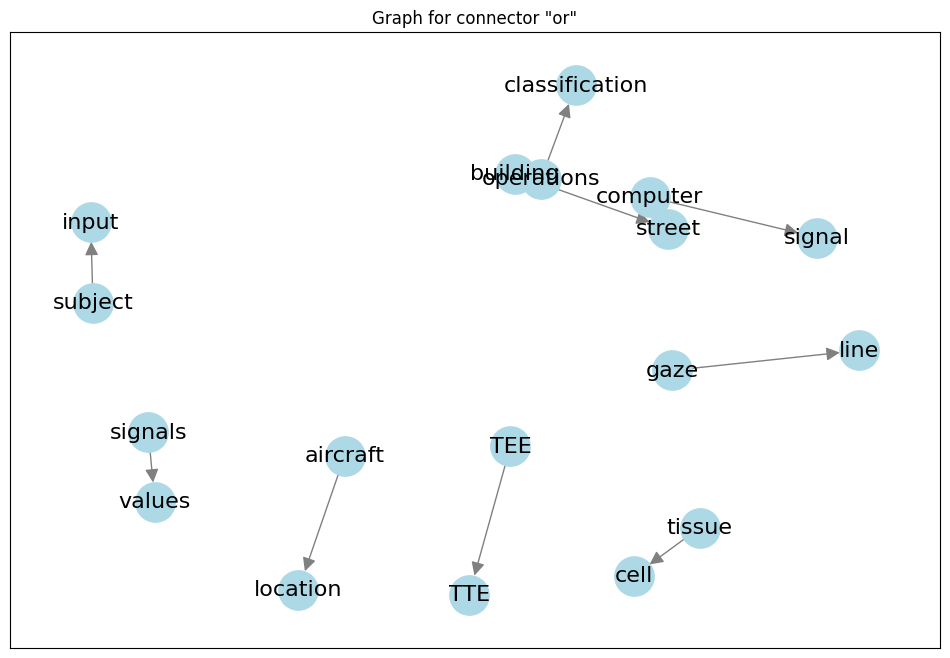

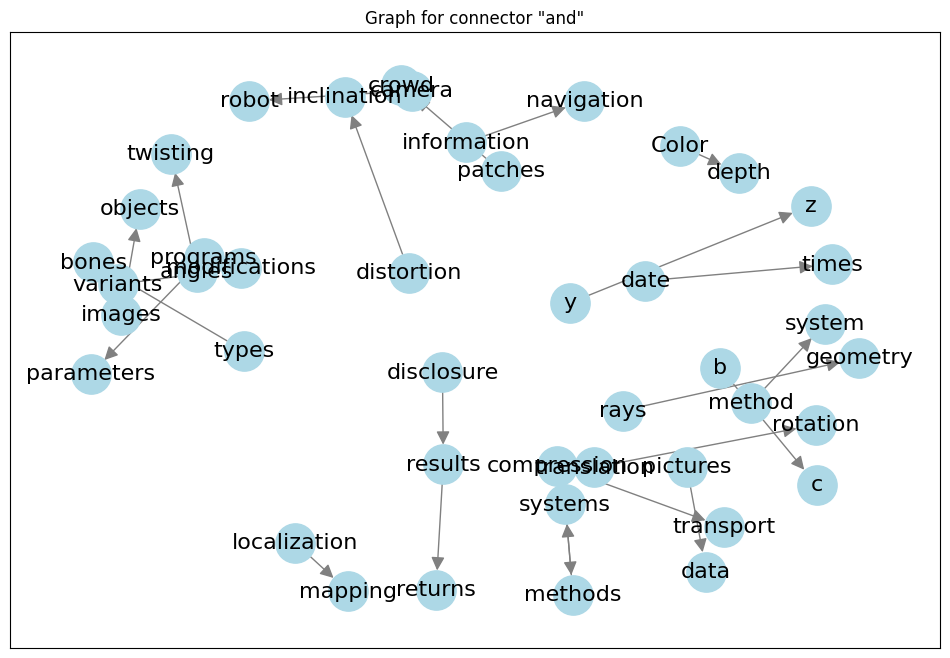

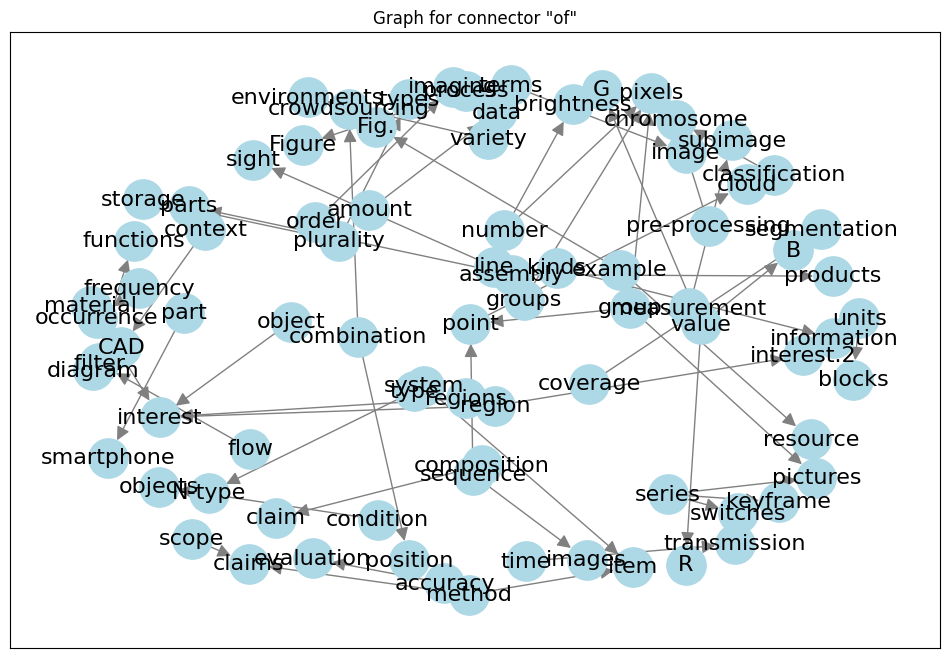

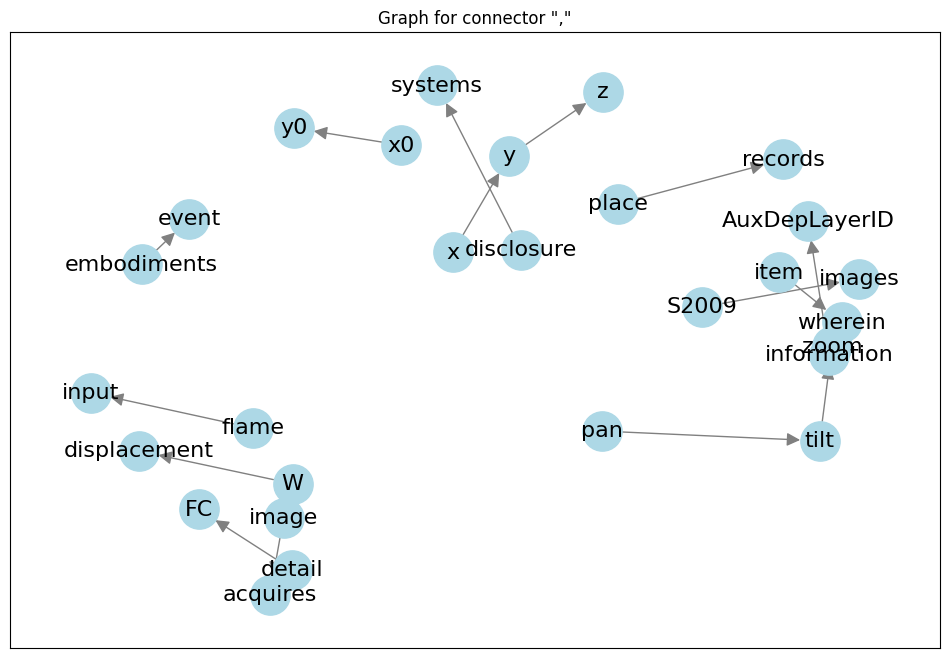

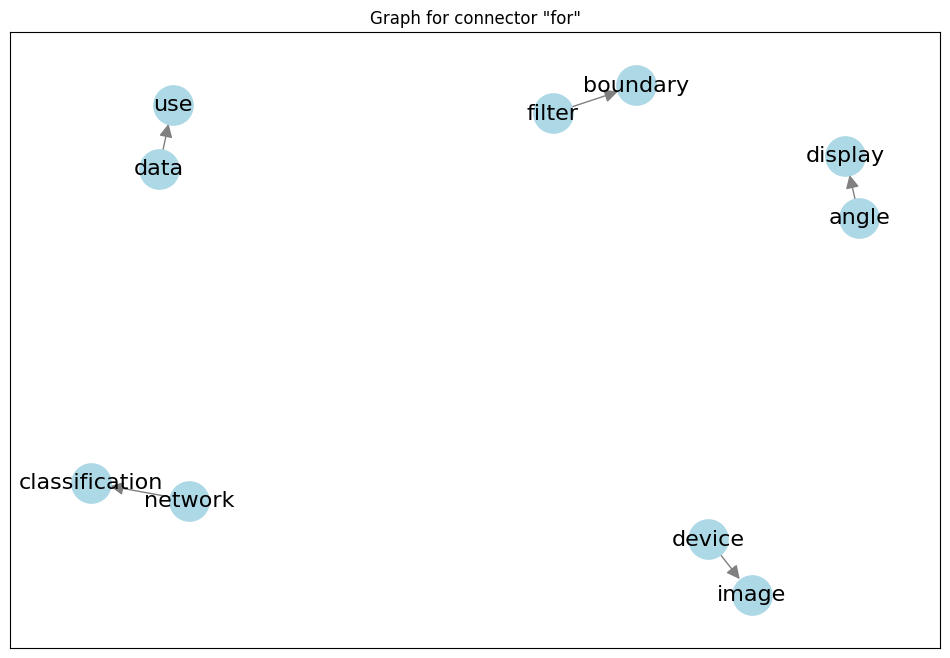

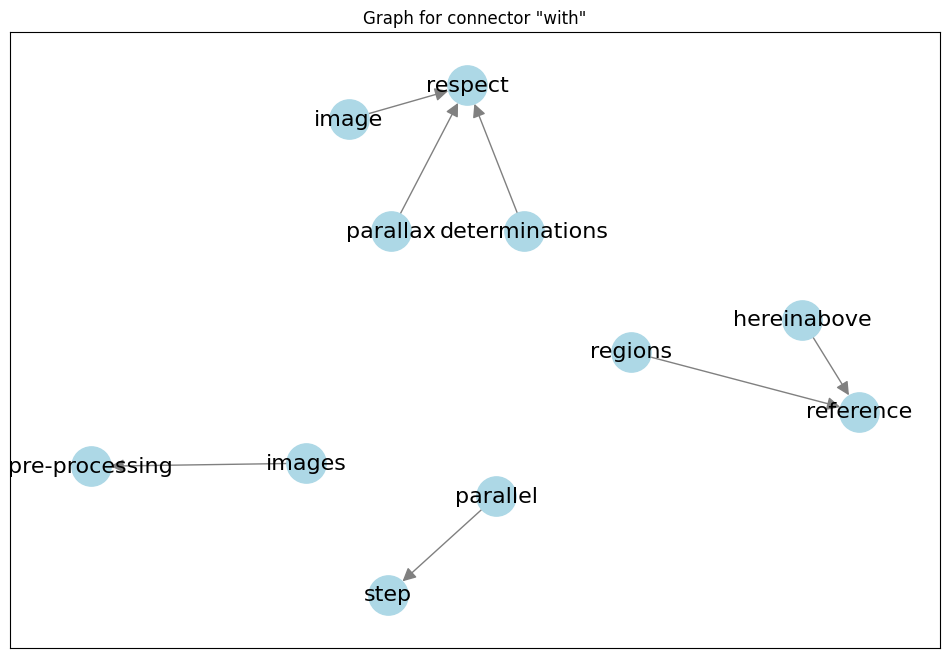

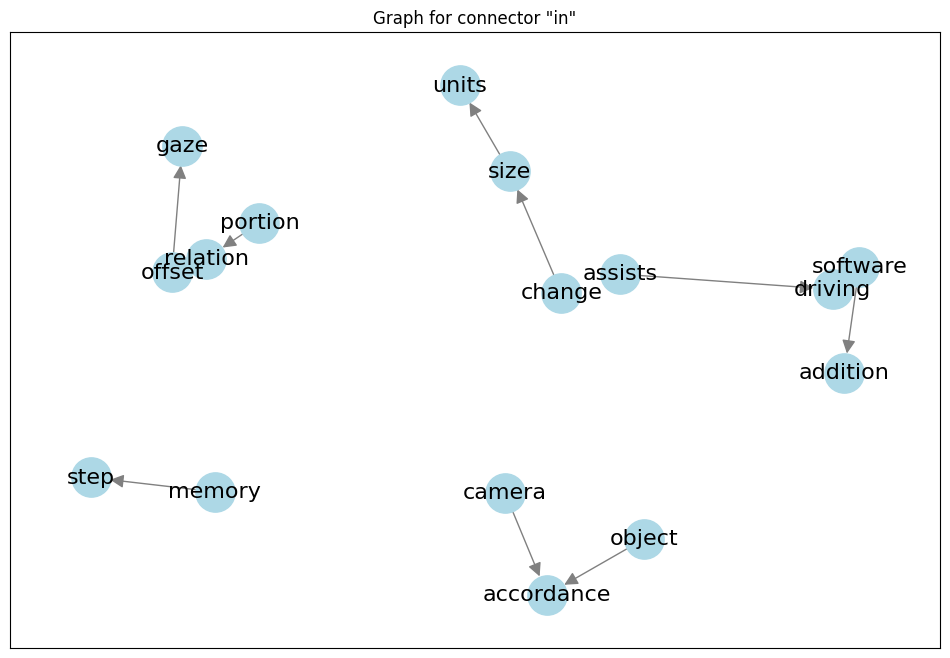

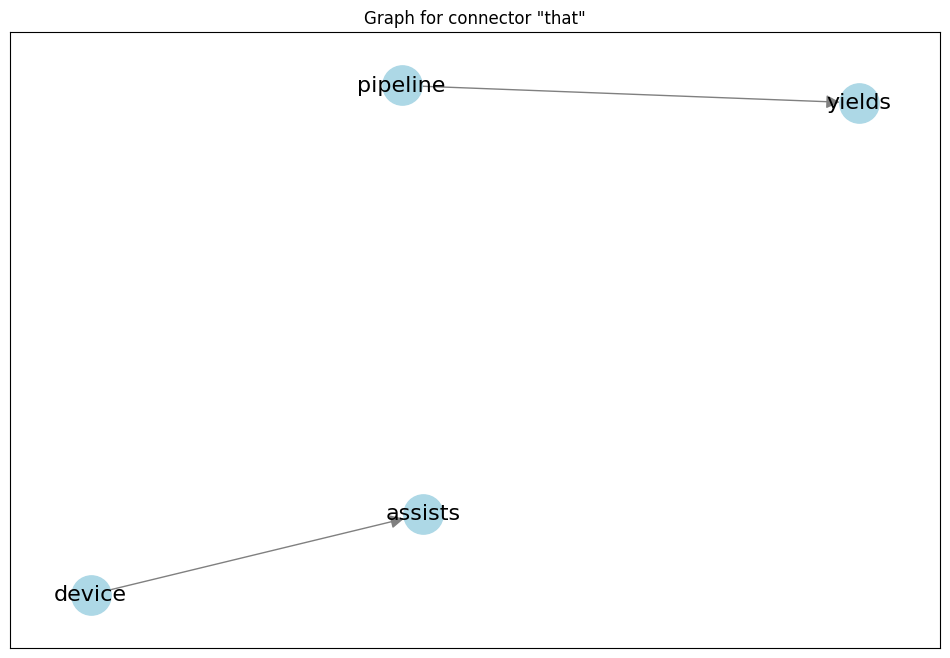

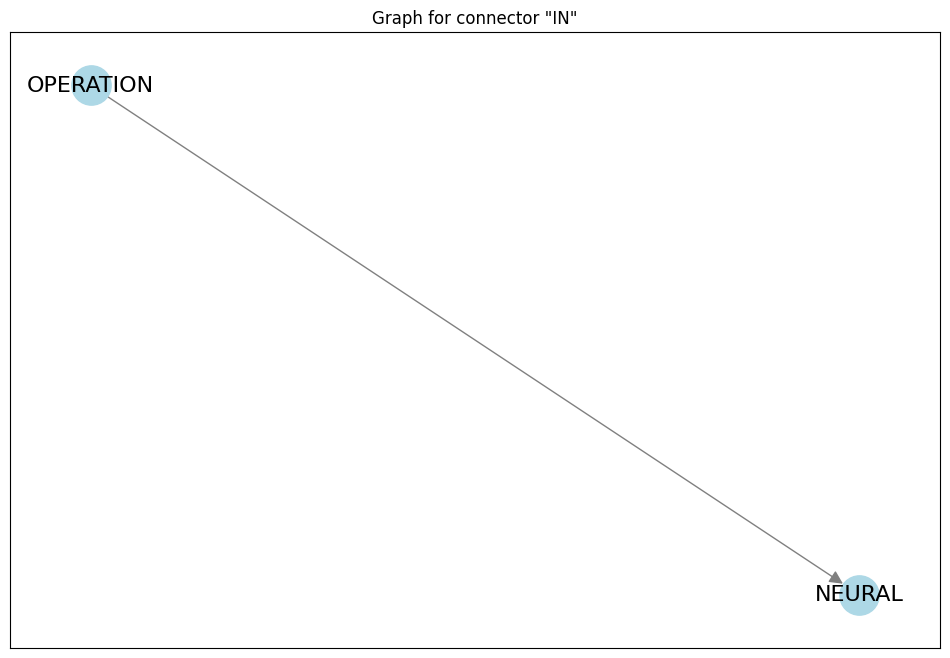

In [181]:
graphs = {}

# Create an empty set to store unique triplets
unique_triplets = set()

co_occurrences = []

for line in test_lines[100:200]:
    line_co_occurrences = get_co_occurrence(line)
    if line_co_occurrences:
        co_occurrences += line_co_occurrences

        df = pd.DataFrame(co_occurrences, columns=['Noun 1', 'Connector', 'Noun 2'])
        unique_df = df.drop_duplicates(subset=['Noun 1', 'Connector', 'Noun 2'])
        unique_triplets.update(set(zip(unique_df['Noun 1'], unique_df['Connector'], unique_df['Noun 2'])))

unique_triplets_df = pd.DataFrame(unique_triplets, columns=['Noun 1', 'Connector', 'Noun 2'])

print(unique_triplets_df.head(20).to_string(index=False))

G = nx.from_pandas_edgelist(unique_triplets_df, source='Connector', target='Noun 2', create_using=nx.DiGraph())

for connector in unique_triplets_df['Connector'].unique():
    if connector not in graphs:
        graphs[connector] = nx.DiGraph()
    sub_df = unique_triplets_df[unique_triplets_df['Connector'] == connector]
    sub_G = nx.from_pandas_edgelist(sub_df, source='Noun 1', target='Noun 2', create_using=nx.DiGraph())
    graphs[connector].add_edges_from(sub_G.edges())

for connector, G in graphs.items():
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.5)
    nx.draw_networkx(G, pos, with_labels=True, node_size=800, node_color='lightblue', edge_color='grey', arrowsize=20, font_size=16)
    plt.title(f'Graph for connector "{connector}"')
    plt.show()

## 🤖 Chat GPT

We are using [OpenAI](https://platform.openai.com/docs/introduction) GPT-3.5 Turbo model and doing some prompt engineering to identify and extract relationships from the text and moreover control the AI's response behavior.

In [32]:
import openai

In [59]:
openai.api_key = "YOUR_API_KEY"
  
def askChatGpt(prompt, model="gpt-3.5-turbo"):
    response = openai.ChatCompletion.create(
        model=model,
        messages=[{"role": "system", "content": "Based on the text, extract the relationships in the format: ___ -> ___ or ___ -> ___ -> ___ according to your best understanding, and give me the type of the relation. No explanation needed. Text: "+prompt}],
        temperature=0.2,
        #max_tokens=150,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0.6,
        stop=["\
        "]
    )
    return response

relationships = askChatGpt("".join(test_lines[100:120]))

In [63]:
print("TEXT : ", "".join(test_lines[100:120])[0:1000])

TEXT :  The computer (for example, memory, processor, storage component, etc.) may be accessed by authorized users. Authorized users may include at least one engineer, technician, surgeon, physician, nurse, and/or health care provider, manufacturer, etc.As a first wash, 1 mL of 0.2% (v/v) Pluronic/PBS was added and the supernatant was removed by centrifugation. As a second wash, 1 mL of 0.2% (v/v) Pluronic/PBS was added and the supernatant was removed by centrifugation. As a third wash, 1 mL of Ventana's 1× reaction buffer was added and the supernatant was removed by centrifugation. 100 µL of 0.2% (v/v) Pluronic/PBS was added and resuspended.That is, the controller 1800 may detect coordinate information of a contact point where extension lines of line segments classified as a group meet as coordinate information of the vanishing point.As described above, according to this modification, the threshold calculation unit 214 calculates an average value of three or more pieces of tomographic

In [60]:
print(relationships.choices[0].message.content)

Computer -> authorized users (relation: access)
Wash 1 -> centrifugation -> Wash 2 -> centrifugation -> Wash 3 -> centrifugation -> resuspension (relation: procedure)
Controller 1800 -> coordinate information (relation: detection)
Threshold calculation unit 214 -> tomographic data -> average value calculation (relation: calculation)
OCTA image generation unit 215 -> tomographic data -> threshold comparison -> pixel value determination (relation: calculation)
Photographing -> date and time -> detailed step -> elapsed time -> worker head position -> worker hand position (relation: inclusion)
Equation 1 -> Euclidean transformation matrix (relation: equality)
Information display process -> AR helmet screen display -> cloud user information system -> end device (relation: illustration)
AR glasses screen -> interaction scenarios (relation: illustration)
Request -> video recording/capture -> graphical representation overlay (relation: action)
Computer system -> wrist orientation -> surgical i

# 🔮 Futher work 
- We want to utilize [Langchain](https://python.langchain.com/en/latest/modules/chains/index_examples/chat_vector_db.html) for exploring the patent, particularly focusing on the Chat Over Documents with Chat History feature. We tried but the server is always overloaded with other requests.

- Combine your models with other relevant data sources, such as research papers, technical reports, or news articles, to provide a richer context for the technical terms and their relationships.

- Explore state-of-the-art techniques for term detection and relation extraction also identifying areas for improvement.
- Complete our Hyponymy and hypernymy detection


### ⚗️ Hyponymy and hypernymy

In [118]:
# nlp = spacy.load("./sci_spacy_output/model-best")

# def hearst_patterns(text):
#     patterns = [
#         (r"(?P<NP1>\b(?:\w+\s*)+\b)(?:, such as |, including |, especially |, notably |, among them | such as )(?P<NP2>.+?)(?=,|\.)",
#          lambda m: (m.group("NP1"), m.group("NP2"))),
#     ]

#     for pattern, action in patterns:
#         regex = re.compile(pattern)
#         for match in regex.finditer(text):
#             yield action(match)

# def extract_hypernyms_hyponyms(text):
#     document = nlp(text)
#     np_chunks = list(document.noun_chunks)

#     np_chunks_text = {str(chunk): chunk for chunk in np_chunks}
#     text_with_placeholders = document.text

#     for idx, chunk in enumerate(np_chunks):
#         text_with_placeholders = text_with_placeholders.replace(
#             str(chunk), "{" + str(idx) + "}")

#     results = list(hearst_patterns(text_with_placeholders))

#     hypernyms_hyponyms = []

#     for hypernym, hyponyms_str in results:
#         hypernym_idx = int(hypernym.strip("{}"))
#         hypernym = np_chunks[hypernym_idx]
#         hyponyms = [np_chunks[int(hyponym.strip("{}"))] for hyponym in re.findall(r'{\d+}', hyponyms_str)]
#         hypernyms_hyponyms.append((hypernym, hyponyms))

#     return hypernyms_hyponyms

# hypernyms_hyponyms = extract_hypernyms_hyponyms(''.join(test_lines[100:110]))
# print(hypernyms_hyponyms)